In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models
from keras.utils import to_categorical
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, RandomFlip, RandomBrightness, RandomZoom, RandomContrast, RandomTranslation, Dropout, BatchNormalization, AvgPool2D
from keras.applications import VGG16, EfficientNetV2L, InceptionResNetV2
from keras import callbacks, backend as K


2023-10-21 20:41:10.593547: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 20:41:11.137799: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
x=np.load('Xtrain_Classification1.npy')
y=np.load('ytrain_Classification1.npy')
first_time = True
len(np.where(y==1)[0])/len(y)

0.14326830828269907

In [28]:
batch_size=20
epochs=100
lr=0.005
image = (x[3,:]).astype('float32')/255.0
train_images = (x).astype('float32')/255.0
train_labels = to_categorical(y,2)

X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2)

model_MLP = models.Sequential()
model_MLP.add(Dense(16,activation = 'relu',input_dim = 2352))
model_MLP.add(Dense(8,activation = 'relu'))
model_MLP.add(Dense(2,activation = 'softmax'))

model_MLP.summary()

adam = optimizers.Adam(learning_rate = lr)
model_MLP.compile(optimizer = adam,
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])
history_mlp = model_MLP.fit(x = X_train,y=y_train,epochs = epochs,batch_size=batch_size,validation_data = (X_val,y_val),verbose = 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                37648     
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 2)                 18        
                                                                 
Total params: 37,802
Trainable params: 37,802
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
251/251 [==============================] - 1s 2ms/step - loss: 0.4260 - accuracy: 0.8525 - val_loss: 0.3908 - val_accuracy: 0.8609
Epoch 2/100
251/251 [==============================] - 0s 2ms/step - loss: 0.3934 - accuracy: 0.8557 - val_loss: 0.3774 - val_accuracy: 0.8609
Epoch 3/100
251/251 [=======

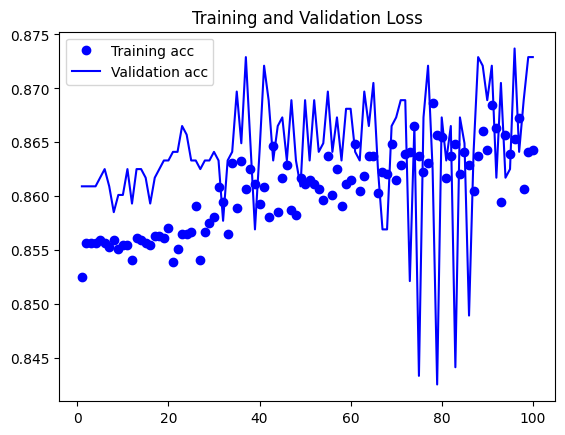

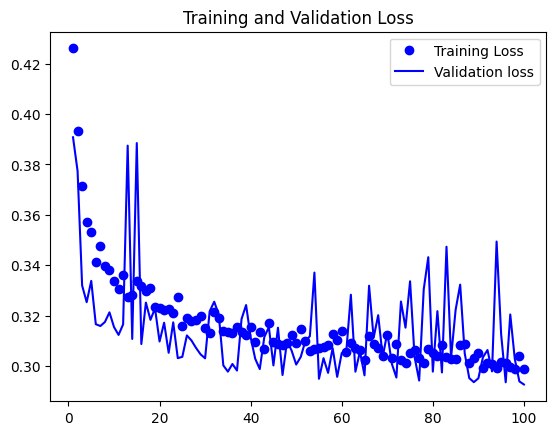

In [29]:
acc = history_mlp.history['accuracy']
val_acc = history_mlp.history['val_accuracy']
loss = history_mlp.history['loss']
val_loss = history_mlp.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc'),
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss'),
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#x = np.load('Xtrain_Classification1.npy')
#test_images = (x).astype('float32')/255.0
#results_MLP = np.argmax(model_MLP.predict(test_images),1)

In [3]:
batch_size=20
epochs=100
train_images = (x).astype('float32')/255.0
train_labels = to_categorical(y,2)
train_images = np.reshape(train_images, (6254,28,28,3))
X_train, X_val, y_train, y_val = train_test_split(train_images, train_labels, test_size=0.2, random_state=0)

model_cnn = models.Sequential()
model_cnn.add(Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(Conv2D(64, (3,3), activation='relu'))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(Conv2D(64, (3,3), activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation = 'relu'))
model_cnn.add(Dense(2, activation = 'softmax'))
model_cnn.summary()

model_cnn.compile(optimizer = optimizers.RMSprop(learning_rate=1e-4),
              loss = 'categorical_crossentropy',
              metrics=[keras.metrics.TruePositives(name='tp'), keras.metrics.FalsePositives(name='fp'), keras.metrics.TrueNegatives(name='tn'), keras.metrics.FalseNegatives(name='fn'),['accuracy']])
history_cnn = model_cnn.fit(x = X_train ,y=y_train ,epochs = epochs ,batch_size=batch_size ,validation_data = (X_val,y_val) ,verbose = 1, callbacks=[TrainBalancedAccuracyCallback(), ValBalancedAccuracyCallback()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

2023-10-17 19:43:53.960877: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 19:43:53.975417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 19:43:53.975558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

NameError: name 'TrainBalancedAccuracyCallback' is not defined

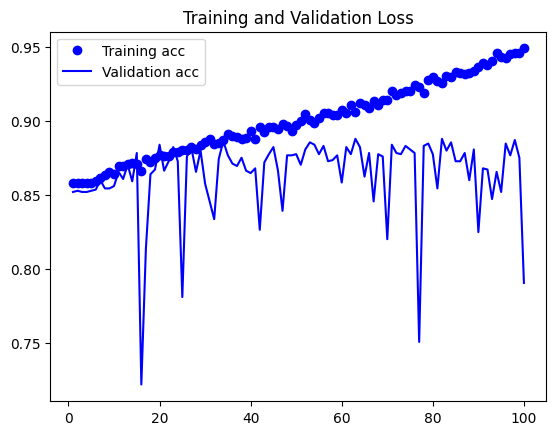

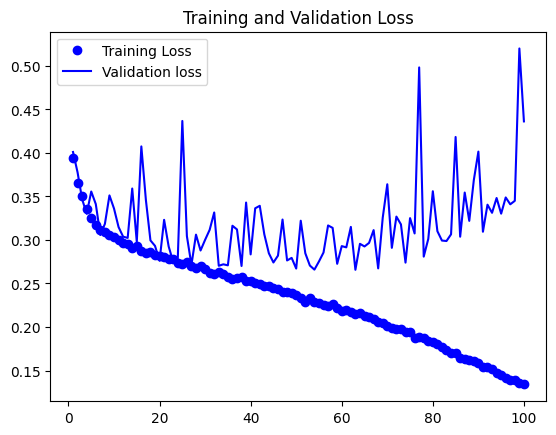

In [51]:
acc = history_cnn.history['accuracy']
val_acc = history_cnn.history['val_accuracy']
loss = history_cnn.history['loss']
val_loss = history_cnn.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc'),
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss'),
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

#x = np.load('Xtrain_Classification1.npy')
#test_images = (x).astype('float32')/255.0
#results_MLP = np.argmax(model_MLP.predict(test_images),1)

In [3]:
def augmentate_melanoma_data(melanoma_images, X_mela, y_mela, num_mela):
  zoom_data = models.Sequential([
    RandomZoom(height_factor=0.2, fill_mode='nearest'),
  ])
  bright_data = models.Sequential([
    RandomBrightness(factor=0.3, value_range=[0.0, 1.0]),
  ])
  translation_data = models.Sequential([
    RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
  ])

  augmented_images = tf.image.flip_left_right(melanoma_images)
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))
  augmented_images = zoom_data(melanoma_images).numpy()
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))
  augmented_images = bright_data(melanoma_images).numpy()
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))
  augmented_images = translation_data(melanoma_images).numpy()
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))  

  num_mela = len(y_mela)

  return num_mela, X_mela, y_mela

def augmentate_all_data(all_images, all_labels):
  all_labels_aug = np.empty((1,), dtype=np.int8)
  all_images_aug = np.empty((1,28,28,3), dtype=np.float32)

  contrast_data = models.Sequential([
    RandomContrast(factor=0.2),
  ])
  augmented_images = contrast_data(all_images).numpy()
  all_images_aug = np.vstack([all_images_aug, augmented_images])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))
  rotated_90 = tf.image.rot90(all_images)
  all_images_aug = np.vstack([all_images_aug, rotated_90])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))
  rotated_180 = tf.image.rot90((all_images), k=2)
  all_images_aug = np.vstack([all_images_aug, rotated_180])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))
  rotated_270 = tf.image.rot90((all_images), k=3)
  all_images_aug = np.vstack([all_images_aug, rotated_270])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))
  
  all_images_aug = all_images_aug[1:]
  all_labels_aug = all_labels_aug[1:]

  return all_images_aug, all_labels_aug


In [66]:
def true_positives(y_true, y_pred):
    y_pred = K.round(y_pred)
    return tf.reduce_sum(tf.cast(tf.math.logical_and(y_true[:, 1] == 1, y_pred[:, 1] == 1), tf.float32))

def false_positives(y_true, y_pred):
    y_pred = K.round(y_pred)
    return tf.reduce_sum(tf.cast(tf.math.logical_and(y_true[:, 1] == 0, y_pred[:, 1] == 1), tf.float32))

def true_negatives(y_true, y_pred):
    y_pred = K.round(y_pred)
    return tf.reduce_sum(tf.cast(tf.math.logical_and(y_true[:, 0] == 1, y_pred[:, 0] == 1), tf.float32))

def false_negatives(y_true, y_pred):
    y_pred = K.round(y_pred)
    return tf.reduce_sum(tf.cast(tf.math.logical_and(y_true[:, 0] == 0, y_pred[:, 0] == 1), tf.float32))

def balanced_accuracy(y_true, y_pred):
    tp = true_positives(y_true, y_pred)
    tn = true_negatives(y_true, y_pred)
    fp = false_positives(y_true, y_pred)
    fn = false_negatives(y_true, y_pred)
    
    numerator = tp * (tn + fp) + tn * (tp + fn)
    denominator = (tn + fp) * (tp + fn)
    
    return numerator / (2*denominator + K.epsilon())

def precision(y_true, y_pred):
    tp = true_positives(y_true, y_pred)
    fp = false_positives(y_true, y_pred)
    
    return tp / (tp + fp + K.epsilon())

def recall(y_true, y_pred):
    tp = true_positives(y_true, y_pred)
    fn = false_negatives(y_true, y_pred)
    
    return tp / (tp + fn + K.epsilon())


# class TrainingAccuracyCallback(tf.keras.callbacks.Callback):
#     def __init__(self, **kargs):
#         super(TrainingAccuracyCallback, self).__init__(**kargs)
        
#     def on_train_begin(self, logs=None):
#         self.train_accuracy = []

#     def on_epoch_end(self, epoch, logs=None):
#         train_accuracy = self.model.evaluate(self.model.validation_data[0], self.model.validation_data[1], verbose=0)[1]
#         self.train_accuracy.append(train_accuracy)
#         print(f" - Train Accuracy: {train_accuracy:.4f}")

# class TrainBalancedAccuracyCallback(callbacks.Callback):

#     def __init__(self, **kargs):
#         super(TrainBalancedAccuracyCallback, self).__init__(**kargs)

#     def on_epoch_end(self, epoch, logs={}):

#         train_sensitivity = logs['tp'] / (logs['tp'] + logs['fn'])
#         train_specificity = logs['tn'] / (logs['tn'] + logs['fp'])
#         logs['train_sensitivity'] = train_sensitivity
#         logs['train_specificity'] = train_specificity
#         logs['train_balacc'] = (train_sensitivity + train_specificity) / 2
#         print(' train_balacc', logs['train_balacc'])
    
# class ValBalancedAccuracyCallback(callbacks.Callback):

#     def __init__(self, **kargs):
#         super(ValBalancedAccuracyCallback, self).__init__(**kargs)

#     def on_epoch_end(self, epoch, logs={}):

#         val_sensitivity = logs['val_tp'] / (logs['val_tp'] + logs['val_fn'])
#         val_specificity = logs['val_tn'] / (logs['val_tn'] + logs['val_fp'])
#         logs['val_sensitivity'] = val_sensitivity
#         logs['val_specificity'] = val_specificity
#         logs['val_balacc'] = (val_sensitivity + val_specificity) / 2
#         print(' val_balacc', logs['val_balacc'])

In [5]:
def split_nevu_mela(x, y):
    train_images = (x).astype('float32')/255.0

    nevu_images = train_images[y == 0]
    melanoma_images = train_images[y == 1]

    y_nevu = y[y == 0]
    y_mela = y[y == 1]

    num_nevu = len((y_nevu))
    num_mela = len((y_mela))

    nevu_images = np.reshape(nevu_images, (num_nevu,28,28,3))
    melanoma_images = np.reshape(melanoma_images, (num_mela,28,28,3))

    return num_nevu, num_mela, nevu_images, melanoma_images, y_nevu, y_mela

def augmentate_melanoma_data(melanoma_images, X_mela, y_mela, num_mela):
  zoom_data = models.Sequential([
    RandomZoom(height_factor=0.2, fill_mode='nearest'),
  ])
  bright_data = models.Sequential([
    RandomBrightness(factor=0.3, value_range=[0.0, 1.0]),
  ])
  translation_data = models.Sequential([
    RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
  ])

  augmented_images = tf.image.flip_left_right(melanoma_images)
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))
  augmented_images = zoom_data(melanoma_images).numpy()
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))
  augmented_images = bright_data(melanoma_images).numpy()
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))
  augmented_images = translation_data(melanoma_images).numpy()
  X_mela = np.vstack([X_mela, augmented_images])
  y_mela = np.hstack((y_mela, np.ones(len(augmented_images,))))  

  num_mela = len(y_mela)

  return num_mela, X_mela, y_mela

def augmentate_all_data(all_images, all_labels):
  all_labels_aug = np.empty((1,), dtype=np.int8)
  all_images_aug = np.empty((1,28,28,3), dtype=np.float32)

  contrast_data = models.Sequential([
    RandomContrast(factor=0.2),
  ])
  augmented_images = contrast_data(all_images).numpy()
  all_images_aug = np.vstack([all_images_aug, augmented_images])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))
  rotated_90 = tf.image.rot90(all_images)
  all_images_aug = np.vstack([all_images_aug, rotated_90])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))
  rotated_180 = tf.image.rot90((all_images), k=2)
  all_images_aug = np.vstack([all_images_aug, rotated_180])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))
  rotated_270 = tf.image.rot90((all_images), k=3)
  all_images_aug = np.vstack([all_images_aug, rotated_270])
  all_labels_aug = np.hstack((all_labels_aug, all_labels))
  
  all_images_aug = all_images_aug[1:]
  all_labels_aug = all_labels_aug[1:]

  return all_images_aug, all_labels_aug


num_nevu, num_mela, nevu_images, melanoma_images, y_nevu, y_mela = split_nevu_mela(x, y)

X_nevu_train, X_nevu_val, y_nevu_train, y_nevu_val = train_test_split(nevu_images, y_nevu, test_size=0.3, random_state=0)
X_mela_train, X_mela_val, y_mela_train, y_mela_val = train_test_split(melanoma_images, y_mela, test_size=0.3, random_state=0)
num_mela, X_mela_train, y_mela_train = augmentate_melanoma_data(melanoma_images, X_mela_train, y_mela_train, num_mela)

X_train = np.vstack([X_mela_train, X_nevu_train])
X_val = np.vstack([X_mela_val, X_nevu_val])
y_train = np.hstack((y_mela_train, y_nevu_train))
y_val = np.hstack((y_mela_val, y_nevu_val)) 

X_train, y_train = augmentate_all_data(X_train, y_train)
X_val, y_val = augmentate_all_data(X_val, y_val)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

print(f"Percentage of Melanoma in train data is {len(np.where(y_train==1)[0])/len(y_train)*100:2.2f}%")
print(f"Percentage of Melanoma in val data is {len(np.where(y_val==1)[0])/len(y_val)*100:2.2f}%")

In [70]:
def display_model_data(history_cnn, prev_history):
    val_balanced_acc = history_cnn.history['val_balanced_accuracy']
    prev_val_balanced_acc = prev_history.history['val_balanced_accuracy']

    if len(val_balanced_acc) > len(prev_val_balanced_acc):
        epochs = range(1, len(prev_val_balanced_acc) + 1)
    else:
        epochs = range(1, len(val_balanced_acc) + 1)
    plt.figure(figsize=(12,6))
    plt.plot(epochs, val_balanced_acc[:max(epochs)], 'r-', label='This CNN')
    plt.plot(epochs, prev_val_balanced_acc[:max(epochs)], 'b', label='Prev CNN'),
    plt.title('Balanced Validation Accuracy')
    plt.legend()
    plt.show()

    # acc = history_cnn.history['train_acc']
    # val_acc = history_cnn.history['val_accuracy']
    # prev_acc = prev_history.history['train_accuracy']
    # prev_val_acc = prev_history.history['val_accuracy']

    # loss = history_cnn.history['loss']
    # val_loss = history_cnn.history['val_loss']
    # prev_loss = prev_history.history['loss']
    # prev_val_loss = prev_history.history['val_loss']

    # fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    # ax1.plot(epochs, acc, 'ro', label='Training acc')
    # ax1.plot(epochs, val_acc, 'r', label='Validation acc')
    # ax1.set_title('This CNN')
    # ax1.legend()
    # # ax1.set_xlim([0,300])
    # ax1.set_ylim([0.4,1])
    # ax2.plot(epochs, prev_acc, 'bo', label='Training acc')
    # ax2.plot(epochs, prev_val_acc, 'b', label='Validation acc')
    # ax2.set_title('Prev CNN')
    # ax2.legend()
    # ax2.set_xlim([0,300])
    # ax2.set_ylim([0.4,1])
    # fig1.suptitle('Training and Validation Accuracy')

    # fig2, (ax3, ax4) = plt.subplots(1, 2, figsize=(12,6))
    # ax3.plot(epochs, loss, 'ro', label='Training loss')
    # ax3.plot(epochs, val_loss, 'r', label='Validation loss')
    # ax3.set_title('This CNN')
    # ax3.legend()
    # # ax3.set_xlim([0,300])
    # ax3.set_ylim([0,4])
    # ax4.plot(epochs, prev_loss, 'bo', label='Training loss')
    # ax4.plot(epochs, prev_val_loss, 'b', label='Validation loss')
    # ax4.set_title('Prev CNN')
    # ax4.legend()
    # # ax4.set_xlim([0,300])
    # ax4.set_ylim([0,4])
    # fig2.suptitle('Training and Validation Loss')

In [63]:
def create_CNN_model(kernel_size):
    model_cnn = models.Sequential()
    model_cnn.add(Conv2D(32, kernel_size, padding='same', activation='relu', input_shape=(28, 28, 3)))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(32, kernel_size, activation='relu'))
    model_cnn.add(AvgPool2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Conv2D(64, kernel_size, padding='same', activation='relu'))
    model_cnn.add(BatchNormalization())
    model_cnn.add(Conv2D(64, kernel_size, activation='relu'))
    model_cnn.add(AvgPool2D(pool_size=(2, 2)))
    model_cnn.add(Dropout(0.25))
    model_cnn.add(Flatten())
    model_cnn.add(Dense(1600, activation='relu'))
    model_cnn.add(Dropout(0.5))
    model_cnn.add(Dense(2, activation='softmax'))
    model_cnn.summary()

    model_cnn.compile(optimizer = optimizers.Adam(learning_rate=1e-3),
                loss = 'categorical_crossentropy',
                metrics=[balanced_accuracy, precision, recall,['accuracy']])
    return model_cnn

In [ ]:
epochs = 500
batch_size = 4381
y_labels = to_categorical(y_train, 2)
X_val = np.reshape(X_val, (len(X_val),28,28,3))
y_val_labels = to_categorical(y_val, 2)
model_cnn = models.Sequential()
model_cnn.add(Conv2D(32, (5,5), padding='same', activation='relu', input_shape=(28,28,3)))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(Conv2D(64, (5,5), padding='same', activation='relu'))
model_cnn.add(MaxPooling2D((2,2)))
model_cnn.add(Conv2D(128, (3,3), padding='same', activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation = 'relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(2, activation = 'softmax'))
model_cnn.summary()

model_cnn.compile(optimizer = optimizers.RMSprop(learning_rate=5e-3),
              loss = 'categorical_crossentropy',
              metrics=[keras.metrics.TruePositives(name='tp'), keras.metrics.FalsePositives(name='fp'), keras.metrics.TrueNegatives(name='tn'), keras.metrics.FalseNegatives(name='fn'),['accuracy']])
history_cnn = model_cnn.fit(x = X_train ,y=y_labels ,epochs = epochs ,batch_size=batch_size ,validation_data = (X_val,y_val_labels) ,verbose = 1,
                             callbacks=[TrainBalancedAccuracyCallback(), ValBalancedAccuracyCallback()])#, keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)])

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 flatten (Flatten)           (None, 6272)            

2023-10-19 18:42:06.164063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-19 18:42:06.571354: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2023-10-19 18:42:06.572975: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2023-10-19 18:42:06.572984: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2023-10-19 18:42:06.573040: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-10-19 

3/3 [==============================] - ETA: 0s - loss: 52.5558 - tp: 4803.0000 - fp: 4855.0000 - tn: 4803.0000 - fn: 4855.0000 - accuracy: 0.4973 train_balacc 0.49730793124870576
 val_balacc 0.5
3/3 [==============================] - 6s 574ms/step - loss: 52.5558 - tp: 4803.0000 - fp: 4855.0000 - tn: 4803.0000 - fn: 4855.0000 - accuracy: 0.4973 - val_loss: 0.6822 - val_tp: 90.0000 - val_fp: 90.0000 - val_tn: 90.0000 - val_fn: 90.0000 - val_accuracy: 0.5000 - train_sensitivity: 0.4973 - train_specificity: 0.4973 - train_balacc: 0.4973 - val_sensitivity: 0.5000 - val_specificity: 0.5000 - val_balacc: 0.5000
Epoch 2/500
2/3 [===================>..........] - ETA: 0s - loss: 0.7823 - tp: 4975.0000 - fp: 3787.0000 - tn: 4975.0000 - fn: 3787.0000 - accuracy: 0.5678 train_balacc 0.5658521433008905
 val_balacc 0.5
3/3 [==============================] - 0s 60ms/step - loss: 1.6410 - tp: 5465.0000 - fp: 4193.0000 - tn: 5465.0000 - fn: 4193.0000 - accuracy: 0.5659 - val_loss: 0.6945 - val_tp: 90.

In [ ]:
best_model = keras.models.load_model('best_mode.h5')
X_test = np.load('Xtest_Classification1.npy')
X_test = np.reshape((X_test).astype('float32')/255.0,(len(X_test),28,28,3))
y_test = best_model.predict(X_test)
print(f"Percentage of Melanoma predictions is {np.count_nonzero(y_test[:,1] > 0.5)/len(y_test)*100:2.2f}%")

In [ ]:
num_nevu, num_mela, nevu_images, melanoma_images, y_nevu, y_mela = split_nevu_mela(x, y)

X_nevu_train, X_nevu_val, y_nevu_train, y_nevu_val = train_test_split(nevu_images, y_nevu, test_size=num_mela*0.15/num_nevu, random_state=0)
X_mela_train, X_mela_val, y_mela_train, y_mela_val = train_test_split(melanoma_images, y_mela, test_size=0.15, random_state=0)
num_mela, X_mela_train, y_mela_train = augmentate_melanoma_data(melanoma_images, X_mela_train, y_mela_train, num_mela)

X_train = np.vstack([X_mela_train, X_nevu_train])
X_val = np.vstack([X_mela_val, X_nevu_val])
y_train = np.hstack((y_mela_train, y_nevu_train))
y_val = np.hstack((y_mela_val, y_nevu_val))

# X_train, y_train = augmentate_all_data(X_train, y_train, X_train, y_train) #result got worse

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

print(f"Percentage of Melanoma in train data is {len(np.where(y_train==1)[0])/len(y_train)*100:2.2f}%")
print(f"Percentage of Melanoma in val data is {len(np.where(y_val==1)[0])/len(y_val)*100}%")


In [20]:
num_nevu, num_mela, nevu_images, melanoma_images, y_nevu, y_mela = split_nevu_mela(x, y)

X_nevu_train, X_nevu_val, y_nevu_train, y_nevu_val = train_test_split(nevu_images, y_nevu, test_size=0.3, random_state=0)
X_mela_train, X_mela_val, y_mela_train, y_mela_val = train_test_split(melanoma_images, y_mela, test_size=0.3, random_state=0)
num_mela, X_mela_train, y_mela_train = augmentate_melanoma_data(melanoma_images, X_mela_train, y_mela_train, num_mela)

X_train = np.vstack([X_mela_train, X_nevu_train])
X_val = np.vstack([X_mela_val, X_nevu_val])
y_train = np.hstack((y_mela_train, y_nevu_train))
y_val = np.hstack((y_mela_val, y_nevu_val)) 

X_train, y_train = augmentate_all_data(X_train, y_train)
X_val, y_val = augmentate_all_data(X_val, y_val)

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

print(f"Percentage of Melanoma in train data is {len(np.where(y_train==1)[0])/len(y_train)*100:2.2f}%")
print(f"Percentage of Melanoma in val data is {len(np.where(y_val==1)[0])/len(y_val)*100:2.2f}%")

Percentage of Melanoma in train data is 52.90%
Percentage of Melanoma in val data is 14.33%


In [132]:
fliph_data = models.Sequential([
RandomFlip("horizontal_and_vertical"),
])
zoom_data = models.Sequential([
RandomZoom(height_factor=0.2, fill_mode='nearest'),
])
bright_data = models.Sequential([
RandomBrightness(factor=0.3, value_range=[0.0, 1.0]),
])
translation_data = models.Sequential([
RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
])

for i in range(1000):
    rotated_90 = tf.image.rot90(tf.convert_to_tensor(X_train[0])).numpy()
    rotated_180 = tf.image.rot90(tf.convert_to_tensor(X_train[0]), k=2).numpy()
    rotated_270 = tf.image.rot90(tf.convert_to_tensor(X_train[0]), k=3).numpy()
    flip = tf.image.flip_left_right(X_train[0])
    zoom = zoom_data(X_train[0]).numpy()
    bright = bright_data(X_train[0]).numpy()
    trans = translation_data(X_train[0]).numpy()
    if np.array_equal(rotated_90, X_train[0]):
        print('True_90')
    if np.array_equal(rotated_180, X_train[0]):
        print('True_180')
    if np.array_equal(rotated_270, X_train[0]):
        print('True_270')
    if np.array_equal(flip, X_train[0]):
        print('True_f')
    if np.array_equal(zoom, X_train[0]):
        print('True_z')
    if np.array_equal(bright, X_train[0]):
        print('True_b')
    if np.array_equal(trans, X_train[0]):
        print('True_t')
    

In [ ]:
i1 = None
i2 = None
for image in X_train:
    for image1 in X_val:
        if np.array_equal(image, image1):
            i1 = image
            i2 = image1
            break
    if i1 is not None:
        break
if i1 or i2 is not None:
    plt.imshow(i1)
    plt.figure(2)
    plt.imshow(i2)
else:
    print('No images repeated found')

In [100]:
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)

In [93]:
epochs = 300
batch_size = 150
y_labels = to_categorical(y_train, 2)
X_val = np.reshape(X_val, (len(X_val),28,28,3))
y_val_labels = to_categorical(y_val, 2)
model_cnn = create_CNN_model((3,3))

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_26 (Bat  (None, 28, 28, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_53 (Conv2D)          (None, 26, 26, 32)        9248      
                                                                 
 average_pooling2d_26 (Avera  (None, 13, 13, 32)       0         
 gePooling2D)                                                    
                                                                 
 dropout_39 (Dropout)        (None, 13, 13, 32)        0         
                                                                 
 conv2d_54 (Conv2D)          (None, 13, 13, 64)      

Epoch 1/300
213/213 [==============================] - ETA: 0s - loss: 0.0341 - balanced_accuracy: 0.9884 - precision: 0.9883 - recall: 0.9899 - accuracy: 0.9884
Epoch 1: val_balanced_accuracy improved from -inf to 0.91462, saving model to cnn_model.h5
213/213 [==============================] - 2s 8ms/step - loss: 0.0341 - balanced_accuracy: 0.9884 - precision: 0.9883 - recall: 0.9899 - accuracy: 0.9884 - val_loss: 0.6813 - val_balanced_accuracy: 0.9146 - val_precision: 0.5190 - val_recall: 0.9848 - val_accuracy: 0.8619
Epoch 2/300
212/213 [============================>.] - ETA: 0s - loss: 0.0267 - balanced_accuracy: 0.9906 - precision: 0.9901 - recall: 0.9922 - accuracy: 0.9906
Epoch 2: val_balanced_accuracy did not improve from 0.91462
213/213 [==============================] - 2s 8ms/step - loss: 0.0267 - balanced_accuracy: 0.9907 - precision: 0.9901 - recall: 0.9922 - accuracy: 0.9906 - val_loss: 0.7545 - val_balanced_accuracy: 0.9104 - val_precision: 0.5073 - val_recall: 0.9832 - 

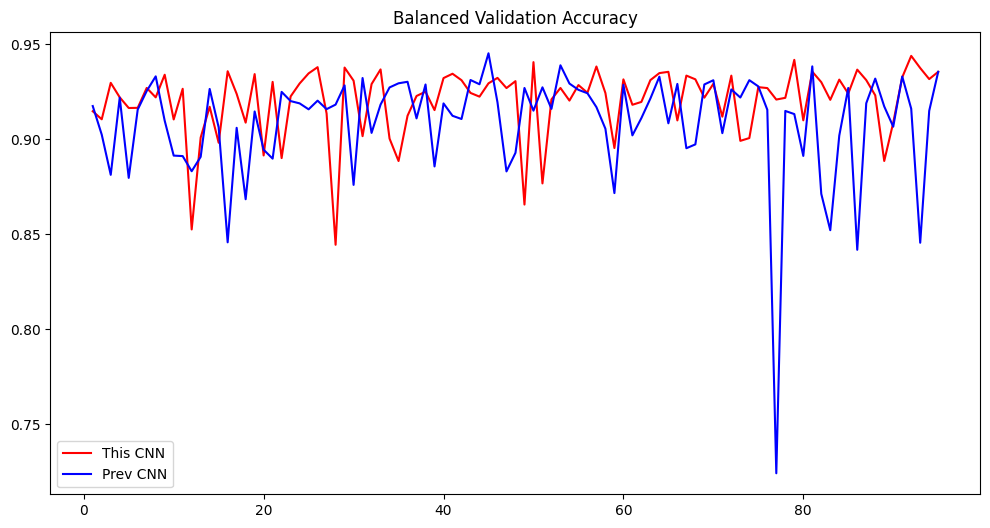

This CNN: [0.9389765858650208, 0.9405283331871033, 0.9026938080787659, 0.9214475154876709, 0.9375113844871521, 0.9397206902503967, 0.9365209937095642, 0.9050343632698059, 0.9276226758956909, 0.9269917607307434, 0.939117431640625, 0.9171680212020874, 0.9218975305557251, 0.9266918301582336, 0.9387526512145996, 0.9350923299789429, 0.9303864240646362, 0.9166849851608276, 0.9379681348800659, 0.9155190587043762, 0.9368013143539429, 0.9204188585281372, 0.9284396171569824, 0.9122448563575745, 0.8803302049636841, 0.9151544570922852, 0.9324960708618164, 0.9223349094390869, 0.9391058087348938, 0.9246973991394043, 0.9250494241714478, 0.931921660900116, 0.9245612025260925, 0.9324838519096375, 0.9134697914123535, 0.9318260550498962, 0.923991858959198, 0.9252088665962219, 0.9325423836708069, 0.9225856065750122, 0.9206357002258301, 0.9397333264350891, 0.9393967390060425, 0.9348126649856567, 0.9253451228141785, 0.9167265892028809, 0.9066645503044128, 0.9353587627410889, 0.9315391778945923, 0.9373471736

In [94]:
history_cnn = best_model.fit(x=X_train ,y=y_labels ,epochs=epochs ,batch_size=batch_size ,validation_data=(X_val,y_val_labels) ,verbose=1,
                           callbacks=[keras.callbacks.EarlyStopping(monitor='val_balanced_accuracy', patience=50, restore_best_weights=True),
                                      keras.callbacks.ModelCheckpoint('cnn_model.h5', verbose=1, monitor= "val_balanced_accuracy", save_best_only=True)])
if first_time:
    prev_history = history_cnn
    prev_model = model_cnn
    first_time = False
display_model_data(history_cnn, prev_history)
print(f'This CNN: {history_cnn.history["val_balanced_accuracy"][::-1]}')
print(f'Prev CNN: {prev_history.history["val_balanced_accuracy"][::-1]}')
prev_model.summary()
prev_history = history_cnn
prev_model = model_cnn

In [81]:
best_history = history_cnn #100 batch_size
best_model = model_cnn
print(best_history.history['val_balanced_accuracy'][::-1])
keras.models.save_model(best_model, 'best_model.h5')

[0.9296037554740906, 0.9253382682800293, 0.9279530048370361, 0.9294486045837402, 0.8947063088417053, 0.924633800983429, 0.9290404915809631, 0.9192749857902527, 0.9263961315155029, 0.9235795736312866, 0.9221094250679016, 0.9222288727760315, 0.9211083650588989, 0.933263897895813, 0.9220494627952576, 0.930840253829956, 0.9348143339157104, 0.9352971911430359, 0.9305440187454224, 0.9293144345283508, 0.9332985877990723, 0.9243150949478149, 0.9242256283760071, 0.9133195281028748, 0.923386812210083, 0.927563488483429, 0.9235178232192993, 0.9366384744644165, 0.9205454587936401, 0.9167258739471436, 0.9267645478248596, 0.9297756552696228, 0.9169709086418152, 0.9204679727554321, 0.9257184863090515, 0.9170079231262207, 0.9292119741439819, 0.9311229586601257, 0.9058955311775208, 0.9304153323173523, 0.9194833636283875, 0.9241447448730469, 0.9368268251419067, 0.9133480191230774, 0.9184601306915283, 0.9227909445762634, 0.9325416684150696, 0.9330137968063354, 0.9243262410163879, 0.9131224751472473, 0.94

In [97]:
X_test = np.load('Xtest_Classification1.npy')
X_test = np.reshape((X_test).astype('float32')/255.0,(len(X_test),28,28,3))
y_test = best_model.predict(X_test)
# best_model.summary()
y_test = y_test.round()
print(f"Percentage of Melanoma predictions is {np.count_nonzero(y_test[:,1] == 1)/len(y_test)*100:2.2f}%")
y_test = np.argmax(y_test, axis=1)
y_test = np.reshape(y_test,(len(y_test),1))
np.save('ytest_Classification1.npy', y_test)

56/56 [==============================] - 0s 1ms/step
Percentage of Melanoma predictions is 20.63%


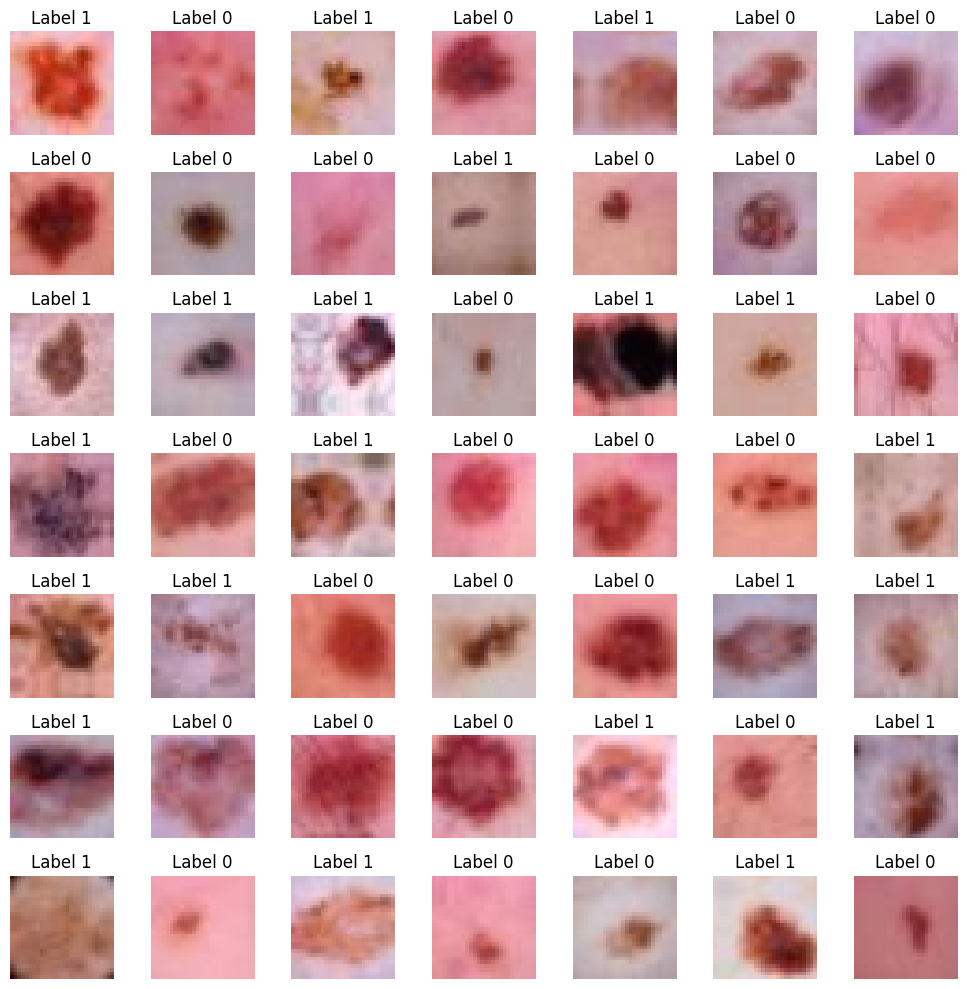

In [23]:
# Display training images
n = 49*3
images = X_train[n:49+n]
labels = y_train[n:49+n]
rows, cols = 7, 7
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i in range(rows):
    for j in range(cols):
        ax = axes[i, j]
        image = images[i*rows + j]
        ax.imshow(image, interpolation='nearest')
        ax.set_title(f"Label {labels[i*cols + j]:1.0f}")
        ax.axis('off')
plt.tight_layout()
plt.show()

In [26]:
# Cross Validation with balanced data on the validation set
num_nevu, num_mela, nevu_images, melanoma_images, y_nevu, y_mela = split_nevu_mela(x, y)
num_mela, X_mela_aug, y_mela_aug = augmentate_melanoma_data(melanoma_images, melanoma_images, y_mela, num_mela)
all_images = np.vstack([X_mela_aug, nevu_images])
all_labels = np.hstack([y_mela_aug, y_nevu])
all_images_aug = np.empty((1,28,28,3), dtype=np.float32)
all_labels_aug = np.empty((1,), dtype=np.int8)
all_images_aug, all_labels_aug = augmentate_all_data(all_images, all_labels)
all_images_aug, all_labels_aug = shuffle(all_images_aug, all_labels_aug, random_state=0)

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
epochs = 232
batch_size = 100
model_history = []
for train_index, val_index in kf.split(all_images_aug, all_labels_aug):
    X_train, X_val = all_images_aug[train_index], all_images_aug[val_index]
    y_train, y_val = all_labels_aug[train_index], all_labels_aug[val_index]
    
    y_labels = to_categorical(y_train, 2)
    y_val_labels = to_categorical(y_val, 2)
    model_history.append(model_cnn.fit(x=X_train ,y=y_labels ,epochs=epochs ,batch_size=batch_size ,validation_data=(X_val,y_val_labels) ,verbose=1,
                             callbacks=[keras.callbacks.ModelCheckpoint('cnn_model.h5', verbose=1, monitor= "val_balanced_accuracy", save_best_only=True)]))#, keras.callbacks.EarlyStopping(monitor='val_balacc', patience=50, restore_best_weights=True)]))

    print(f'Size of the training fold is {len(y_train)}')
    print(f'Size of the validation fold is {len(y_val)}')
    print(f'Class imbalance in Train is {np.count_nonzero(y_train==1)/len(y_train):2.2f}%')
    print(f'Class imbalance in Validation is {np.count_nonzero(y_val==1)/len(y_val):2.2f}%')
    

Epoch 1/232
237/237 [==============================] - ETA: 0s - loss: 0.5450 - tp: 18341.0000 - fp: 5270.0000 - tn: 18341.0000 - fn: 5270.0000 - accuracy: 0.7768 train_balacc 0.7767989496421159
 val_balacc 0.8036591563611722

Epoch 1: val_balacc improved from -inf to 0.80366, saving model to cnn_model.h5
237/237 [==============================] - 2s 8ms/step - loss: 0.5450 - tp: 18341.0000 - fp: 5270.0000 - tn: 18341.0000 - fn: 5270.0000 - accuracy: 0.7768 - val_loss: 0.4091 - val_tp: 4744.0000 - val_fp: 1159.0000 - val_tn: 4744.0000 - val_fn: 1159.0000 - val_accuracy: 0.8037 - train_sensitivity: 0.7768 - train_specificity: 0.7768 - train_balacc: 0.7768 - val_sensitivity: 0.8037 - val_specificity: 0.8037 - val_balacc: 0.8037
Epoch 2/232
233/237 [============================>.] - ETA: 0s - loss: 0.3987 - tp: 18706.0000 - fp: 4594.0000 - tn: 18706.0000 - fn: 4594.0000 - accuracy: 0.8028 train_balacc 0.8033967218669265
 val_balacc 0.7829916991360325

Epoch 2: val_balacc did not improve f

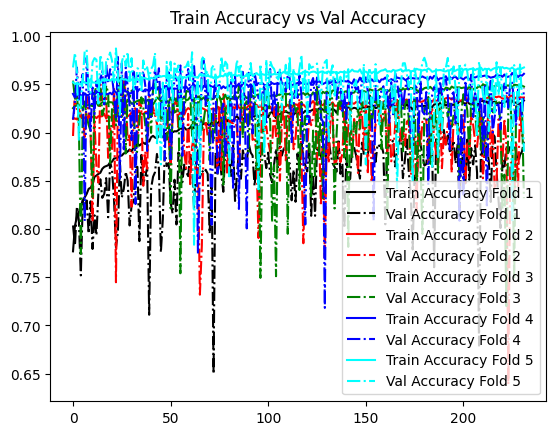

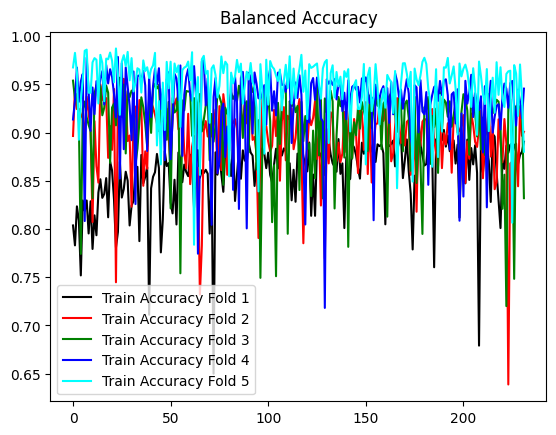

In [27]:
plt.figure()
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='cyan', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='cyan', linestyle = "dashdot")
plt.legend()
plt.show()

plt.figure()
plt.title('Balanced Accuracy')
plt.plot(model_history[0].history['val_balacc'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[1].history['val_balacc'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[2].history['val_balacc'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[3].history['val_balacc'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_history[4].history['val_balacc'], label='Train Accuracy Fold 5', color='cyan', )
plt.legend()
plt.show()

In [80]:
best_model = keras.models.load_model('best_mode.h5', compile=False)
best_model.compile(optimizer = optimizers.Adam(learning_rate=1e-3),
                loss = 'categorical_crossentropy',
                metrics=[balanced_accuracy, precision, recall,['accuracy']])
best_model.summary()
X_test = np.load('Xtest_Classification1.npy')
X_test = np.reshape((X_test).astype('float32')/255.0,(len(X_test),28,28,3))
y_test = best_model.predict(X_test)
print(f"Percentage of Melanoma predictions is {np.count_nonzero(y_test[:,1] > 0.5)/len(y_test)*100:2.2f}%")

#y_test = model_cnn.predict(X_test)
#print(f"Percentage of Melanoma predictions is {np.count_nonzero(y_test[:,1] > 0.5)/len(y_test)*100:2.2f}%")

Model: "sequential_119"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_104 (Conv2D)         (None, 26, 26, 32)        896       
                                                                 
 batch_normalization_52 (Bat  (None, 26, 26, 32)       128       
 chNormalization)                                                
                                                                 
 conv2d_105 (Conv2D)         (None, 24, 24, 32)        9248      
                                                                 
 average_pooling2d_50 (Avera  (None, 12, 12, 32)       0         
 gePooling2D)                                                    
                                                                 
 dropout_78 (Dropout)        (None, 12, 12, 32)        0         
                                                                 
 conv2d_106 (Conv2D)         (None, 10, 10, 64)     

In [ ]:
# Cross Validation with unbalanced data on the validation set
num_nevu, num_mela, nevu_images, melanoma_images, y_nevu, y_mela = split_nevu_mela(x, y)
all_images = np.vstack([melanoma_images, nevu_images])
all_labels = np.hstack([y_mela, y_nevu])

all_images_aug, all_labels_aug = augmentate_all_data(all_images, all_labels)
all_images_aug, all_labels_aug = shuffle(all_images_aug, all_labels_aug, random_state=0)

n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=0)
epochs = 232
batch_size = 100
model_history = []
model_cnn = create_CNN_model()
for train_index, val_index in kf.split(all_images_aug, all_labels_aug):
    X_train, X_val = all_images_aug[train_index], all_images_aug[val_index]
    y_train, y_val = all_labels_aug[train_index], all_labels_aug[val_index]
    
    X_train = np.reshape(X_train,(len(X_train),2352))
    num_nevu, num_mela, nevu_images, melanoma_images, y_nevu, y_mela = split_nevu_mela(X_train, y_train)
    num_mela, X_mela_aug, y_mela_aug = augmentate_melanoma_data(melanoma_images, melanoma_images, y_mela, num_mela)
    X_train = np.vstack([X_mela_aug, nevu_images])
    y_train = np.hstack([y_mela_aug, y_nevu])
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    y_labels = to_categorical(y_train, 2)
    y_val_labels = to_categorical(y_val, 2)
    model_history.append(model_cnn.fit(x=X_train ,y=y_labels ,epochs=epochs ,batch_size=batch_size ,validation_data=(X_val,y_val_labels) ,verbose=1,
                             callbacks=[keras.callbacks.ModelCheckpoint('cnn_model.h5', verbose=1, monitor= "val_balanced_accuracy", save_best_only=True)]))#, keras.callbacks.EarlyStopping(monitor='val_balacc', patience=50, restore_best_weights=True)]))

    print(f'Size of the training fold is {len(y_train)}')
    print(f'Size of the validation fold is {len(y_val)}')
    print(f'Class imbalance in Train is {np.count_nonzero(y_train==1)/len(y_train):2.2f}%')
    print(f'Class imbalance in Validation is {np.count_nonzero(y_val==1)/len(y_val):2.2f}%')

In [ ]:
plt.figure()
plt.title('Train Accuracy vs Val Accuracy')
plt.plot(model_history[0].history['accuracy'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[0].history['val_accuracy'], label='Val Accuracy Fold 1', color='black', linestyle = "dashdot")
plt.plot(model_history[1].history['accuracy'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[1].history['val_accuracy'], label='Val Accuracy Fold 2', color='red', linestyle = "dashdot")
plt.plot(model_history[2].history['accuracy'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[2].history['val_accuracy'], label='Val Accuracy Fold 3', color='green', linestyle = "dashdot")
plt.plot(model_history[3].history['accuracy'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_history[3].history['val_accuracy'], label='Val Accuracy Fold 4', color='blue', linestyle = "dashdot")
plt.plot(model_history[4].history['accuracy'], label='Train Accuracy Fold 5', color='cyan', )
plt.plot(model_history[4].history['val_accuracy'], label='Val Accuracy Fold 5', color='cyan', linestyle = "dashdot")
plt.legend()
plt.show()

plt.figure()
plt.title('Balanced Accuracy')
plt.plot(model_history[0].history['val_balacc'], label='Train Accuracy Fold 1', color='black')
plt.plot(model_history[1].history['val_balacc'], label='Train Accuracy Fold 2', color='red', )
plt.plot(model_history[2].history['val_balacc'], label='Train Accuracy Fold 3', color='green', )
plt.plot(model_history[3].history['val_balacc'], label='Train Accuracy Fold 4', color='blue', )
plt.plot(model_history[4].history['val_balacc'], label='Train Accuracy Fold 5', color='cyan', )
plt.legend()
plt.show()

In [ ]:
best_model = keras.models.load_model('cnn_model.h5')
X_test = np.load('Xtest_Classification1.npy')
X_test = np.reshape((X_test).astype('float32')/255.0,(len(X_test),28,28,3))
y_test = best_model.predict(X_test)
print(f"Percentage of Melanoma predictions is {np.count_nonzero(y_test[:,1] > 0.5)/len(y_test)*100:2.2f}%")

y_test = model_cnn.predict(X_test)
print(f"Percentage of Melanoma predictions is {np.count_nonzero(y_test[:,1] > 0.5)/len(y_test)*100:2.2f}%")

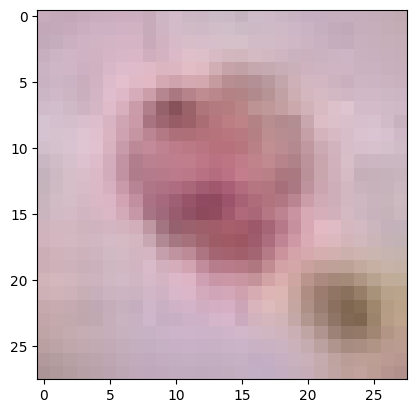

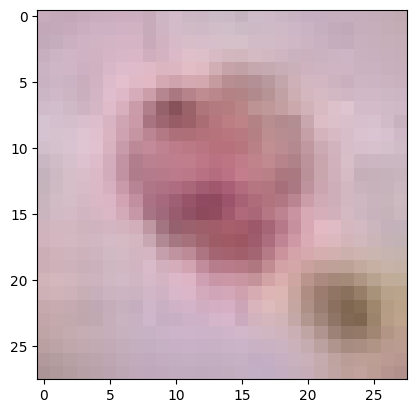

In [6]:

images = np.reshape((x).astype('float32')/255.0,(len(x),28,28,3))
image = images[0]
plt.imshow(image, interpolation='nearest')
plt.show()
output_image = tf.image.resize(image, (32, 32), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy()
plt.imshow(image, interpolation='nearest')
plt.show()

In [ ]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
#conv_base = EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(32,32,3))
conv_base.trainable = False

model = models.Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1280, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(2, activation='softmax'))
model.summary()

model.compile(optimizer = optimizers.RMSprop(learning_rate=1e-4),
            loss = 'categorical_crossentropy',
            metrics=[keras.metrics.TruePositives(name='tp'), keras.metrics.FalsePositives(name='fp'), keras.metrics.TrueNegatives(name='tn'), keras.metrics.FalseNegatives(name='fn'),['accuracy']])


In [ ]:
epochs = 232
batch_size = 100
X_train = tf.image.resize(X_train, (32, 32), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy()
X_val = tf.image.resize(X_val, (32, 32), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy()
y_labels = to_categorical(y_train, 2)
y_val_labels = to_categorical(y_val, 2)

history_cnn = model.fit(x=X_train ,y=y_labels ,epochs=epochs ,batch_size=batch_size ,validation_data=(X_val,y_val_labels) ,verbose=1,
                           callbacks=[TrainBalancedAccuracyCallback(), ValBalancedAccuracyCallback()])#, keras.callbacks.EarlyStopping(monitor='val_balacc', patience=50, restore_best_weights=True)])
if first_time:
    prev_history = history_cnn
    first_time = False
display_model_data(history_cnn, prev_history)
prev_history = history_cnn

In [22]:
X_test = np.load('Xtest_Classification1.npy')   
X_test = np.reshape((X_test).astype('float32')/255.0,(len(X_test),28,28,3))
X_test = tf.image.resize(X_test, (32, 32), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy()
y_test = model.predict(X_test)
print(f"Percentage of Melanoma predictions is {np.count_nonzero(y_test[:,1] > 0.5)/len(y_test)*100:2.2f}%")


56/56 [==============================] - 4s 24ms/step
Percentage of Melanoma predictions is 3.29%


In [212]:
svc = SVC(kernel='rbf', C=1.0)
X_train = np.reshape(X_train, (len(X_train), 2352))
svc.fit(X_train, y_train)
X_val = np.reshape(X_val, (len(X_val), 2352))

balanced_acc = balanced_accuracy_score(y_val, svc.predict(X_val))
print("Balanced Validation Accuracy:", balanced_acc)

Balanced Validation Accuracy: 0.789655058813738
